In [1]:
!pip install yfinance pandas numpy matplotlib plotly scikit-learn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
print("All packages imported successfully!")

# Test yfinance
sp500 = yf.download('^GSPC', start='2024-01-01', end='2025-09-01')
print(sp500.head())

All packages imported successfully!


/tmp/ipython-input-1699730439.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2024-01-01', end='2025-09-01')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2024-01-02  4742.830078  4754.330078  4722.669922  4745.200195  3743050000
2024-01-03  4704.810059  4729.290039  4699.709961  4725.069824  3950760000
2024-01-04  4688.680176  4726.779785  4687.529785  4697.419922  3715480000
2024-01-05  4697.240234  4721.490234  4682.109863  4690.569824  3844370000
2024-01-08  4763.540039  4764.540039  4699.819824  4703.700195  3742320000


[*********************100%***********************]  1 of 1 completed


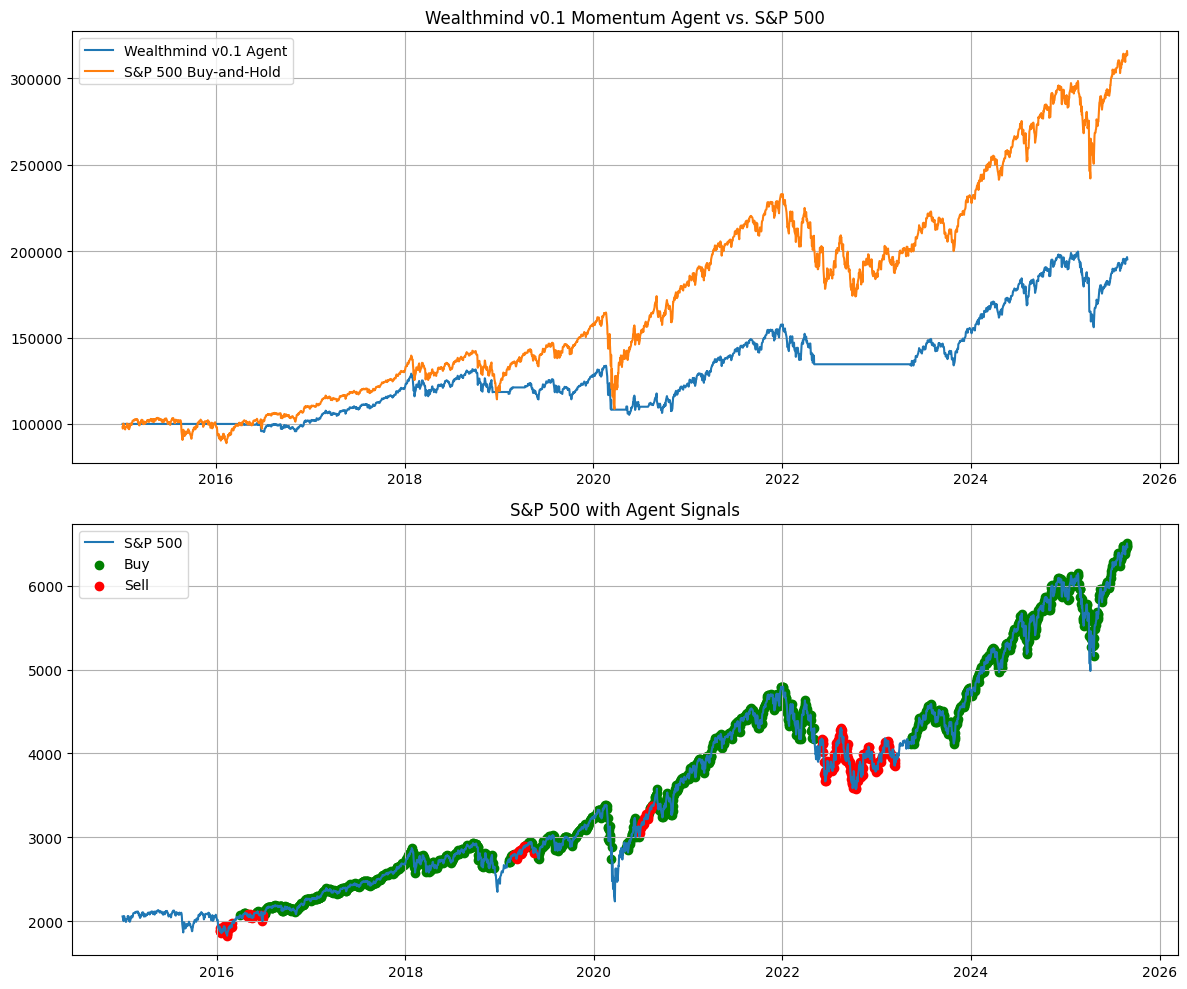

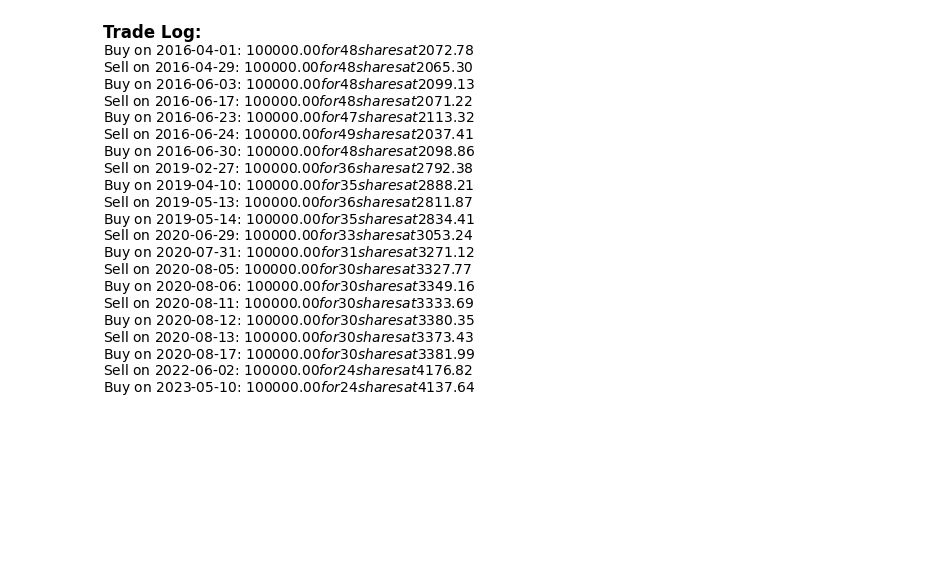

Performance Metrics: {'Annualized Return': np.float64(7.097121131191028), 'Sharpe Ratio': np.float64(0.5625986742796926), 'Max Drawdown': -21.936553741920285}


In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class MomentumAgent:
    def __init__(self, ticker='^GSPC', start_date='2015-01-01', end_date='2025-09-01'):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.position = 0
        self.portfolio_value = 100000  # Initial investment
        self.trades = []

    def fetch_data(self):
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, interval='1d', auto_adjust=False)
        self.data = self.data[['Close']].copy()
        self.data.to_csv('sp500_data.csv')  # Save for reproducibility

    def calculate_momentum(self):
        self.data['1Y_Return'] = self.data['Close'].pct_change(periods=252) * 100
        self.data['6M_Return'] = self.data['Close'].pct_change(periods=126) * 100
        # Calculate MACD components
        self.data['Fast_MA'] = self.data['Close'].rolling(window=130).mean()  # 26 weeks
        self.data['Slow_MA'] = self.data['Close'].rolling(window=260).mean()  # 52 weeks
        self.data['MACD'] = self.data['Fast_MA'] - self.data['Slow_MA']

    def generate_signals(self):
        self.data['Signal'] = 0
        # Buy: 1-year momentum up
        self.data.loc[self.data['1Y_Return'] > 0, 'Signal'] = 1
        # Sell: Both 6-month momentum and MACD are negative
        self.data.loc[(self.data['6M_Return'] < 0) & (self.data['MACD'] < 0), 'Signal'] = -1

    def execute_trades(self):
        self.data['Position'] = self.data['Signal'].replace(-1, 0).ffill()
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Strategy_Return'] = self.data['Position'].shift(1) * self.data['Daily_Return']
        self.data['Cumulative_Strategy'] = (1 + self.data['Strategy_Return']).cumprod() * self.portfolio_value
        self.data['Cumulative_Benchmark'] = (1 + self.data['Daily_Return']).cumprod() * self.portfolio_value

        for date, row in self.data.iterrows():
            if row['Signal'].item() == 1 and self.position == 0:
                shares = self.portfolio_value / row['Close'].item()  # Number of shares
                self.trades.append(f"Buy on {date.date()}: ${self.portfolio_value:.2f} for {shares:.0f} shares at ${row['Close'].item():.2f}")
                self.position = 1
            elif row['Signal'].item() == -1 and self.position == 1:
                shares = self.portfolio_value / row['Close'].item()  # Number of shares
                self.trades.append(f"Sell on {date.date()}: ${self.portfolio_value:.2f} for {shares:.0f} shares at ${row['Close'].item():.2f}")
                self.position = 0

    def evaluate_performance(self):
        annualized_return = self.data['Strategy_Return'].mean() * 252 * 100
        sharpe_ratio = (self.data['Strategy_Return'].mean() / self.data['Strategy_Return'].std()) * np.sqrt(252)
        max_drawdown = (self.data['Cumulative_Strategy'] / self.data['Cumulative_Strategy'].cummax() - 1).min() * 100
        return {
            'Annualized Return': annualized_return,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown
        }

    def visualize(self):
        # Plot 1: Cumulative Returns
        plt.figure(figsize=(12, 10))
        plt.subplot(2, 1, 1)  # Two rows, one column, first plot
        plt.plot(self.data['Cumulative_Strategy'], label='Wealthmind v0.1 Agent')
        plt.plot(self.data['Cumulative_Benchmark'], label='S&P 500 Buy-and-Hold')
        plt.title('Wealthmind v0.1 Momentum Agent vs. S&P 500')
        plt.legend()
        plt.grid(True)

        # Plot 2: S&P 500 Price with Signals
        plt.subplot(2, 1, 2)  # Two rows, one column, second plot
        plt.plot(self.data['Close'], label='S&P 500')
        plt.scatter(self.data.index[self.data['Signal'] == 1], self.data['Close'][self.data['Signal'] == 1], color='g', label='Buy')
        plt.scatter(self.data.index[self.data['Signal'] == -1], self.data['Close'][self.data['Signal'] == -1], color='r', label='Sell')
        plt.title('S&P 500 with Agent Signals')
        plt.legend()
        plt.grid(True)

        # Adjust layout to make space for trades below
        plt.tight_layout()
        plt.savefig('signals.png')
        plt.show()

        # Plot trades as text in a new figure with single spacing
        plt.figure(figsize=(12, len(self.trades) * 0.3 + 1))  # Dynamic height based on number of trades
        plt.text(0.1, 0.95, 'Trade Log:', fontsize=12, fontweight='bold')
        for i, trade in enumerate(self.trades):
            plt.text(0.1, 0.95 - (i + 1) * 0.03, trade, fontsize=10)  # Offset 0.03 for single spacing
        plt.axis('off')  # Hide axes for clean text display
        plt.savefig('trades.png')
        plt.show()

    def run(self):
        self.fetch_data()
        self.calculate_momentum()
        self.generate_signals()
        self.execute_trades()
        metrics = self.evaluate_performance()
        self.visualize()
        print("Performance Metrics:", metrics)
        # Trades are displayed in the plot, so no need to print separately

# Run the agent
agent = MomentumAgent()
agent.run()